<a href="https://colab.research.google.com/github/PatelKartik-lgm/Azure-OpenAI-SQL/blob/master/LayoutLMv2/RVL-CDIP/Fine_tuning_LayoutLMv2ForSequenceClassification_on_RVL_CDIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we are going to fine-tune `LayoutLMv2ForSequenceClassification` on the [RVL-CDIP](https://www.cs.cmu.edu/~aharley/rvl-cdip/#:~:text=The%20RVL%2DCDIP%20(Ryerson%20Vision,images%2C%20and%2040%2C000%20test%20images.) dataset, which is a document image classification task. Each scanned document in the dataset belongs to one of 16 classes, such as "resume" or "invoice" (so it's a multiclass classification problem). The entire dataset consists of no less than 400,000 (!) scanned documents.

For demonstration purposes, we are going to fine-tune the model on a really small subset (one example per class), and verify whether the model is able to overfit them. Note that LayoutLM achieves state-of-the-art results on RVL-CDIP, with a classification accuracy of 94.42% on the test set.

* Original LayoutLMv2 paper: https://arxiv.org/abs/2012.14740

## Setting up environment

We install HuggingFace Transformers and Detectron2.

In [1]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
!pip install -q pyyaml==5.1
# workaround: install old version of pytorch since detectron2 hasn't released packages for pytorch 1.9 (issue: https://github.com/facebookresearch/detectron2/issues/3158)
!pip install -q torch==1.8.0+cu101 torchvision==0.9.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

# install detectron2 that matches pytorch 1.8
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
#!pip install -q detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
!python -m pip install -q 'git+https://github.com/facebookresearch/detectron2.git'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 16.0 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
ERROR: Could not find a version that satisfies the requirement torch==1.8.0+cu101 (from versions: 1.13.0, 1.13.0+cpu, 1.13.0+cu116, 1.13.0+cu117, 1.13.0+cu117.with.pypi.cudnn, 1.13.1, 1.13.1+cpu, 1.13.1+cu116, 1.13.1+cu117, 1.13.1+cu117.with.pypi.cudnn, 2.0.0, 2.0.0+cpu, 2.0.0+cpu.cxx11.abi, 2.0.0+cu117, 2.0.0+cu117.with.pypi.cudnn, 2.0.0+cu118, 2.0.1, 2.0.1+cpu, 2.0.1+cpu.cxx11.abi, 2.0.1+cu117, 2.0.1+cu117.with.pypi.cudnn, 2.0

In [3]:
!pip install -q datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 7.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cuda-nvrtc-cu12==12

We also install PyTesseract:

In [4]:
! sudo apt install tesseract-ocr
! pip install -q pytesseract

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 18 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 2s (2,143 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debc

## Getting the data

Next, we download a small subset of the RVL-CDIP dataset (which I prepared), containing 15 documents (one example per class). I omitted the "handwritten" class, because the OCR results were mediocre.


In [5]:
import requests, zipfile, io

def download_data():
    url = "https://www.dropbox.com/s/kuw05qmc4uy474d/RVL_CDIP_one_example_per_class.zip?dl=1"
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall()

download_data()

Let's look at a random training example (in this case, a resume):


In [ ]:
from PIL import Image, ImageDraw, ImageFont

image = Image.open("/content/RVL_CDIP_one_example_per_class/memo/Tax_invoice.png")
image = image.convert("RGB")
image

We can use the Tesseract OCR engine to turn the image into a list of recognized words:

In [33]:
import pytesseract
import numpy as np

ocr_df = pytesseract.image_to_data(image, output_type='data.frame')
ocr_df = ocr_df.dropna().reset_index(drop=True)
float_cols = ocr_df.select_dtypes('float').columns
ocr_df[float_cols] = ocr_df[float_cols].round(0).astype(int)
ocr_df = ocr_df.replace(r'^\s*$', np.nan, regex=True)
words = ' '.join([word for word in ocr_df.text if str(word) != 'nan'])
words

'Your Company Name SP ee ORO RS Pal ae ei) BILL TO Contact Name Client Company Name Address. Phone Pee Remarks / Payment instructions: Phone Number, Email INVOICE DATE: INVOICE NO: <Payment terms (due on receipt, due in X days)> SHIP TO Name / Dept Client Company Name (ess SUBTOTAL, DISCOUNT TAX RATE TOTAL TAX SHIPPING/HANDLING it eer'

However, we can use `LayoutLMv2Processor` to easily prepare the data for the model. We give a document image as input to the processor, and it will create `input_ids`, `attention_mask`, `token_type_ids` and `bbox` for us. Internally, it will apply PyTesseract to get the words and bounding boxes, it will normalize the bounding boxes according to the size of the image, and it will turn everything into token-level inputs. It will also resize the document image to 224x224, as the model also requires an `image` input. Handy, isn't it?

Btw, if you prefer to use your own OCR engine, you still can. In that case, you can provide your own words and (normalized) bounding boxes to the processor.

In [34]:
from transformers import LayoutLMv2FeatureExtractor, LayoutLMv2Tokenizer, LayoutLMv2Processor

feature_extractor = LayoutLMv2FeatureExtractor()
tokenizer = LayoutLMv2Tokenizer.from_pretrained("microsoft/layoutlmv2-base-uncased")
processor = LayoutLMv2Processor(feature_extractor, tokenizer)

/usr/local/lib/python3.11/dist-packages/transformers/models/layoutlmv2/feature_extraction_layoutlmv2.py:30: FutureWarning: The class LayoutLMv2FeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use LayoutLMv2ImageProcessor instead.
  warnings.warn(


In [35]:
encoded_inputs = processor(image, return_tensors="pt")

In [36]:
for k,v in encoded_inputs.items():
  print(k, v.shape)

input_ids torch.Size([1, 84])
bbox torch.Size([1, 84, 4])
token_type_ids torch.Size([1, 84])
attention_mask torch.Size([1, 84])
image torch.Size([1, 3, 224, 224])


Let's check whether the `input_ids` are created correctly by decoding them back to text:

In [37]:
processor.tokenizer.decode(encoded_inputs.input_ids.squeeze().tolist())

'[CLS] your company name sp ee oro rs pal ae ei ) bill to contact name client company name address . phone pee remarks / payment instructions : phone number , email invoice date : invoice no : < payment terms ( due on receipt , due in x days ) > ship to name / dept client company name ( ess subtotal , discount tax rate total tax shipping / handling it eer [SEP]'

Note that it also adds the special tokens ([CLS] and [SEP]). You can also pad to a max length, truncate, etc., just like you would do with a regular tokenizer.

## Preprocessing the data using 🤗 datasets

First, we convert the dataset into a Pandas dataframe, having 2 columns: image_path and label.

In [38]:
import pandas as pd
import os

dataset_path = "/content/RVL_CDIP_one_example_per_class"
labels = [label for label in os.listdir(dataset_path)]
id2label = {v: k for v, k in enumerate(labels)}
label2id = {k: v for v, k in enumerate(labels)}
label2id

{'letter': 0,
 'file_folder': 1,
 'budget': 2,
 'advertisement': 3,
 'memo': 4,
 'scientific_publication': 5,
 'resume': 6,
 'presentation': 7,
 'scientific_report': 8,
 'invoice': 9,
 'news_article': 10,
 'specification': 11,
 'form': 12,
 'email': 13,
 'questionnaire': 14}

In [39]:
images = []
labels = []

for label_folder, _, file_names in os.walk(dataset_path):
  if label_folder != dataset_path:
    label = label_folder[40:]
    for _, _, image_names in os.walk(label_folder):
      relative_image_names = []
      for image_file in image_names:
        relative_image_names.append(dataset_path + "/" + label + "/" + image_file)
      images.extend(relative_image_names)
      labels.extend([label] * len (relative_image_names))

data = pd.DataFrame.from_dict({'image_path': images, 'label': labels})
data.head()

,image_path,label
0,/content/RVL_CDIP_one_example_per_class/letter...,letter
1,/content/RVL_CDIP_one_example_per_class/file_f...,file_folder
2,/content/RVL_CDIP_one_example_per_class/budget...,budget
3,/content/RVL_CDIP_one_example_per_class/advert...,advertisement
4,/content/RVL_CDIP_one_example_per_class/memo/0...,memo


In [40]:
from datasets import Dataset

# read dataframe as HuggingFace Datasets object
dataset = Dataset.from_pandas(data)

In [41]:
dataset

Dataset({
    features: ['image_path', 'label'],
    num_rows: 16
})

In [42]:
from datasets import Features, Sequence, ClassLabel, Value, Array2D, Array3D

# we need to define custom features
features = Features({
    'image': Array3D(dtype="int64", shape=(3, 224, 224)),
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'attention_mask': Sequence(Value(dtype='int64')),
    'token_type_ids': Sequence(Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'labels': ClassLabel(num_classes=len(labels), names=labels),
})

def preprocess_data(examples):
  # take a batch of images
  images = [Image.open(path).convert("RGB") for path in examples['image_path']]

  encoded_inputs = processor(images, padding="max_length", truncation=True)

  # add labels
  encoded_inputs["labels"] = [label2id[label] for label in examples["label"]]

  return encoded_inputs

encoded_dataset = dataset.map(preprocess_data, remove_columns=dataset.column_names, features=features,
                              batched=True, batch_size=2)

ValueError: Some label names are duplicated. Each label name should be unique.

Next, we set the format to PyTorch tensors. We also specify to put everything on the GPU (CUDA).

In [43]:
encoded_dataset.set_format(type="torch", device="cuda")

We can create a PyTorch dataloader now:

In [44]:
import torch

dataloader = torch.utils.data.DataLoader(encoded_dataset, batch_size=4)
batch = next(iter(dataloader))

In [45]:
for k,v in batch.items():
  print(k, v.shape)

image torch.Size([4, 3, 224, 224])
input_ids torch.Size([4, 512])
attention_mask torch.Size([4, 512])
token_type_ids torch.Size([4, 512])
bbox torch.Size([4, 512, 4])
labels torch.Size([4])


In [46]:
processor.tokenizer.decode(batch['input_ids'][0].tolist())

'[CLS] received mar 22 1973 1270 avenue of the americas pr . 1 . w . hughes 4 law offices . yacob & medinger rockefeller center new york , n . y . 10020 maren 18 , 1979 dr . t . w . hughes research director . brown & willianson tobacco corp 1600 west hill street lovisvilie , kentucky 40201 dear wally : for your information , i am enclosing herewith a recent paper by lehrer , et ei . entitled immunogenic properties of tobacco smoke [ the journal of allergy and clinical tununvlogy 62 ( 6 ) : 368 - 370 ; december , 1978 ] . sincerely , la timothy m . finnegai wo ke ay bom wd tle ww pw ? epezoobos [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PA

In [47]:
id2label[batch['labels'][0].item()]

'letter'

## Define the model

Here we define the model, namely `LayoutLMv2ForSequenceClassification`. We initialize it with the weights of the pre-trained base model (`LayoutLMModel`). The weights of the classification head are randomly initialized, and will be fine-tuned together with the weights of the base model on our tiny dataset. Once loaded, we move it to the GPU.

In [48]:
from transformers import LayoutLMv2ForSequenceClassification
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LayoutLMv2ForSequenceClassification.from_pretrained("microsoft/layoutlmv2-base-uncased",
                                                            num_labels=len(labels))
model.to(device)

Some weights of LayoutLMv2ForSequenceClassification were not initialized from the model checkpoint at microsoft/layoutlmv2-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


LayoutLMv2ForSequenceClassification(
  (layoutlmv2): LayoutLMv2Model(
    (embeddings): LayoutLMv2Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (x_position_embeddings): Embedding(1024, 128)
      (y_position_embeddings): Embedding(1024, 128)
      (h_position_embeddings): Embedding(1024, 128)
      (w_position_embeddings): Embedding(1024, 128)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (visual): LayoutLMv2VisualBackbone(
      (backbone): FPN(
        (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
        (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
        (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

## Train the model

Here we train the model in familiar PyTorch fashion. We use the Adam optimizer with weight decay fix (normally you can also specify which variables should have weight decay and which not + a learning rate scheduler, see here for how the authors of LayoutLM did this), and train for 30 epochs. If the model is able to overfit it, then it means there are no issues and we can train it on the entire dataset.

In [49]:
from transformers import AdamW
from tqdm.notebook import tqdm

optimizer = AdamW(model.parameters(), lr=5e-5)

global_step = 0
num_train_epochs = 10
t_total = len(dataloader) * num_train_epochs # total number of training steps

#put the model in training mode
model.train()
for epoch in range(num_train_epochs):
  print("Epoch:", epoch)
  running_loss = 0.0
  correct = 0
  for batch in tqdm(dataloader):
      # forward pass
      outputs = model(**batch)
      loss = outputs.loss

      running_loss += loss.item()
      predictions = outputs.logits.argmax(-1)
      correct += (predictions == batch['labels']).float().sum()

      # backward pass to get the gradients
      loss.backward()

      # update
      optimizer.step()
      optimizer.zero_grad()
      global_step += 1

  print("Loss:", running_loss / batch["input_ids"].shape[0])
  accuracy = 100 * correct / len(data)
  print("Training accuracy:", accuracy.item())

Epoch: 0


/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/4 [00:00<?, ?it/s]

Loss: 3.852877696355184
Training accuracy: 6.25
Epoch: 1


  0%|          | 0/4 [00:00<?, ?it/s]

Loss: 3.5197205543518066
Training accuracy: 25.0
Epoch: 2


  0%|          | 0/4 [00:00<?, ?it/s]

Loss: 3.1270904541015625
Training accuracy: 50.0
Epoch: 3


  0%|          | 0/4 [00:00<?, ?it/s]

Loss: 2.992640972137451
Training accuracy: 50.0
Epoch: 4


  0%|          | 0/4 [00:00<?, ?it/s]

Loss: 2.7970131238301597
Training accuracy: 75.0
Epoch: 5


  0%|          | 0/4 [00:00<?, ?it/s]

Loss: 2.4025911490122476
Training accuracy: 75.0
Epoch: 6


  0%|          | 0/4 [00:00<?, ?it/s]

Loss: 2.1440282265345254
Training accuracy: 87.5
Epoch: 7


  0%|          | 0/4 [00:00<?, ?it/s]

Loss: 1.7854987780253093
Training accuracy: 93.75
Epoch: 8


  0%|          | 0/4 [00:00<?, ?it/s]

Loss: 1.5492355823516846
Training accuracy: 93.75
Epoch: 9


  0%|          | 0/4 [00:00<?, ?it/s]

Loss: 1.2486769556999207
Training accuracy: 93.75


## Inference

To perform inference on a new document image, 3 things need to be done:

1. prepare the image for the model using `LayoutLMv2Processor`
2. forward pass through the model
3. convert the output of the model to an actual label name

Let's take the first image of the training dataset as an example.

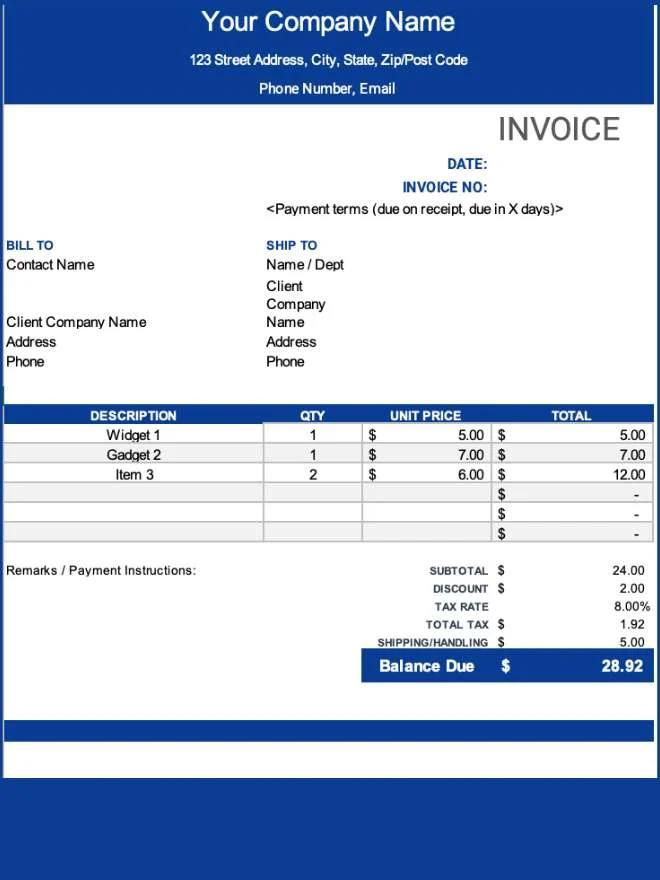

In [50]:
image

In [51]:
# prepare image for the model
encoded_inputs = processor(image, return_tensors="pt")

# make sure all keys of encoded_inputs are on the same device as the model
for k,v in encoded_inputs.items():
  encoded_inputs[k] = v.to(model.device)

# forward pass
outputs = model(**encoded_inputs)

The model outputs `logits` of shape (batch_size, num_labels):

In [52]:
logits = outputs.logits
print(logits.shape)

torch.Size([1, 16])


We simply take the largest logit (i.e. `argmax` on the last dimension), and convert it back to a string using the `id2label` dictionary we created earlier.

In [55]:
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", id2label[predicted_class_idx])

Predicted class: advertisement
